### Demo: training SVM with squared hinge loss model on spam dataset

The loss function for linear support vector machine with the squared hinge loss,
$$\min\limits_{\beta \in \rm I\!R^d} F(\beta):= 1/n\sum_{i=1}^n(max(0, 1-y_ix_i^T\beta))^2 + \lambda\left \| \beta \right \|_2^2$$


Thus the gradient of the loss function can be written as,
$$ \nabla \ F(\beta) = -\frac{2}{n}\sum_{i=1}^n u_{i} v_{i} + 2\lambda\beta $$ 
where $ u_{i} = max(0, 1 - y_{i}x_{i}^T\beta)$ and  $v_{i} = x_{i}y_{i}$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing
import time

#### Load training and testing data, standardize both sets.

In [2]:
# Load the dataset and the test indicator set
spam = pd.read_table('https://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.data', sep=' ', header=None)
test_indicator = pd.read_table('https://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.traintest', sep=' ',
                               header=None)

x = np.asarray(spam)[:, 0:-1]
y = np.asarray(spam)[:, -1]*2 - 1  # Convert to +/- 1
test_indicator = np.array(test_indicator).T[0]

# Divide the data into train, test sets
x_train = x[test_indicator == 0, :]
x_test = x[test_indicator == 1, :]
y_train = y[test_indicator == 0]
y_test = y[test_indicator == 1]

# Standardize the data. 
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Keep track of the number of samples and dimension of each sample
n_train = len(y_train)
n_test = len(y_test)
d = np.size(x, 1)

#### Define all functions.

In [3]:
def objective(beta, lambduh, xy):
    """
    Compute the value of objective function
    :param beta: coefficients
    :param lambduh: Regularization parameter
    :param xy: Precomputed values \sum x_{i1}y_i, ..., \sum x_{id}y_i
    :return: Value of objective function
    """   
    n = np.size(xy, 1)
    return np.linalg.norm(np.maximum(0, 1- np.dot(xy.T, beta)))**2/n + lambduh * np.linalg.norm(beta)**2

def computegrad(beta, lambduh, xy):
    """
    Compute the value of gradient function
    :param beta: coefficients
    :param lambduh: regularization parameter
    :param xy: precomputed values \sum x_{i1}y_i, ..., \sum x_{id}y_i
    :return: value of gradient function
    """
    n = np.size(xy, 1)
    return 2 * ((-1/n) * np.dot(xy, np.maximum(0, 1- np.dot(xy.T, beta))) + lambduh * beta)

def bt_line_search(beta, lambduh, xy, eta, alpha=0.5, betaparam=0.8, maxiter=100):
    """
    Backtracking line search 
    :param beta: coefficients
    :param lambduh: regularization parameter
    :param xy: precomputed values \sum x_{i1}y_i, ..., \sum x_{id}y_i
    :param eta: step size
    :param alpha: constant used to define sufficient decrease condition
    :param betaparam: fraction by which we decrease step size if the previous step size doesn't work
    :param maxiter: maximum iteration times
    :return: eta    
    """
    grad_beta = computegrad(beta, lambduh, xy)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = 0
    iter = 0
    while found_eta == 0 and iter < maxiter:
        if objective(beta - eta * grad_beta, lambduh, xy) < objective(beta, lambduh, xy) \
                - alpha * eta * norm_grad_beta ** 2:
            found_eta = 1
        else:
            eta *= betaparam
            iter += 1
    return eta

def mylinearsvm(beta_init, theta_init, lambduh, eta_init, maxiter, x=x_train, y=y_train):
    """
    Backtracking line search 
    :param beta_init: starting coefficients
    :param theta_init: starting coefficients
    :param lambduh: rgularization parameter
    :param eta_init: initial step size
    :param maxiter: maximum iteration times
    :param x: training predictior data set
    :param y: training response data set
    :return: array of all values of beta  
    """
    xy = np.dot(x.T, np.diag(y))
    beta = beta_init
    theta = theta_init
    grad_theta = computegrad(theta, lambduh, xy)
    beta_vals = beta
    theta_vals = theta
    iter = 0
    while iter < maxiter:
        t0 = time.time()
        eta = bt_line_search(theta, lambduh, xy, eta_init)
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter+3)*(beta_new-beta)
        # Store all of the places we step to
        beta_vals = np.vstack((beta_vals, beta_new))
        theta_vals = np.vstack((theta_vals, theta))
        grad_theta = computegrad(theta, lambduh, xy)
        beta = beta_new
        iter += 1
    return beta_vals

def objective_plot(betas, lambduh, x=x_train, y=y_train):
    """
    Plot objective/loss function value over number of iterations 
    :param beta: coefficients
    :param lambduh: regularization parameter
    :param x: training predictior data set
    :param y: training response data set
    :param maxiter: maximum iteration times
    :return: plot 
    """
    v = np.dot(x.T, np.diag(y))
    num_points = len(betas)
    objs = np.zeros(num_points)
    for i in range(0, num_points):
        objs[i] = objective(betas[i], lambduh, v)
    plt.plot(range(1, num_points + 1), objs)
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.title('Objective value vs. iteration when lambda='+str(lambduh))
    plt.show()
    
def misclassification_error(lambduh, beta, x, y):
    """
    Calculate and print the missiclassification error
    :param beta: coefficients
    :param lambduh: regularization parameter
    :param x: testing predictior data set
    :param y: testing response data set
    :return: missiclassification error
    """
    print("Misclassification Error is: " + str(np.sum(x.dot(beta)*y < 0)/len(y)) + ', when lambda is ' + str(lambduh)) 
    return np.sum(x.dot(beta)*y < 0)/len(y)

def validation(fun, lambduh_tuning, beta_init, theta_init, x_train, x_test, y_train, y_test, max_iter):
    """
    Plot log of missclassification error over minus log of lambduh 
    :param fun: the model function that return an array of all values of beta 
    :param lambduh_tuning: the rgularization parameter going to be tried
    :param theta_init: 
    :param x_train: training predictior data set
    :param y_train: training response data set
    :param x_test: testing predictior data set
    :param y_test: testing response data set
    :param maxiter: maximum iteration times
    :return: plot  
    """    
    n = np.size(lambduh_tuning, 0)
    mse = np.zeros(n) 
    eta = sp.linalg.eigh(1/len(y_train)*x_train.T.dot(x_train), eigvals = (d-1, d-1), eigvals_only=True)[0]  
    for i in range(0, n):
        eta_init = 1/(eta + lambduh_tuning[i])
        betas = fun(beta_init, theta_init, lambduh_tuning[i], eta_init, max_iter, x=x_train, y=y_train)
        beta = betas[-1]
        mse[i] = misclassification_error(lambduh_tuning[i], beta, x_test, y_test)           
    plt.figure()
    plt.plot(-np.log10(lambduh_tuning), np.log(mse))
    plt.ylabel('Log of MSE on Validation Data')
    plt.xlabel('-log(Lambda)')
    plt.title('Misclassification Error vs. Lambda')
    plt.show()

#### Give intial values for all parameters, use mylinearsvm to train a model on the training data, and plot the value of loss function over iterations.

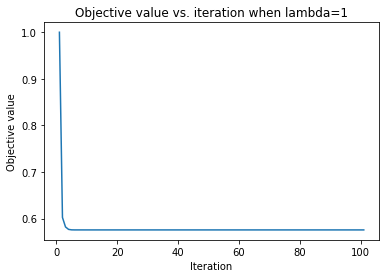

Misclassification Error is: 0.0950520833333, when lambda is 1


0.095052083333333329

In [4]:
beta_init = np.zeros(d)
theta_init = np.zeros(d)
lambduh = 1
eta_init = 1/(sp.linalg.eigh(1/len(y_train)*x_train.T.dot(x_train), eigvals = (d-1, d-1), eigvals_only=True)[0] + lambduh)

betas = mylinearsvm(beta_init, theta_init, lambduh, eta_init, 100)
objective_plot(betas, lambduh)
misclassification_error(lambduh, betas[-1], x_test, y_test)

#### Run cross-validation to find the optimal value of lambduh. Report your misclassification error for that value of lambduh.

Misclassification Error is: 0.0846354166667, when lambda is 1e-10
Misclassification Error is: 0.0846354166667, when lambda is 1e-09
Misclassification Error is: 0.0846354166667, when lambda is 1e-08
Misclassification Error is: 0.0846354166667, when lambda is 1e-07
Misclassification Error is: 0.0846354166667, when lambda is 1e-06
Misclassification Error is: 0.0846354166667, when lambda is 1e-05
Misclassification Error is: 0.0846354166667, when lambda is 0.0001
Misclassification Error is: 0.0833333333333, when lambda is 0.001
Misclassification Error is: 0.083984375, when lambda is 0.01
Misclassification Error is: 0.0911458333333, when lambda is 0.1
Misclassification Error is: 0.0950520833333, when lambda is 1
Misclassification Error is: 0.108072916667, when lambda is 10
Misclassification Error is: 0.114583333333, when lambda is 100
Misclassification Error is: 0.113932291667, when lambda is 1000
Misclassification Error is: 0.113932291667, when lambda is 10000
Misclassification Error is: 0.

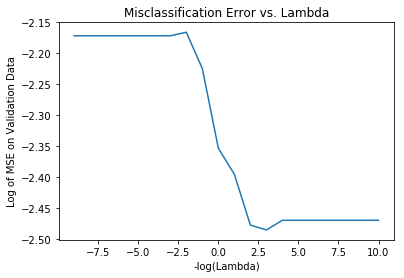

In [5]:
lambduh_tuning = [10**x for x in range(-10, 10, 1)]
beta_init = np.zeros(d)
theta_init = np.zeros(d)
max_iter = 100

validation(mylinearsvm, lambduh_tuning, beta_init, theta_init, x_train, x_test, y_train, y_test, max_iter)

#### From the cross validation plot, we found missclassification error is the lowest (0.0833333) when lambda is 0.001.

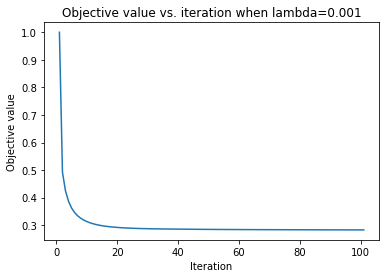

Misclassification Error is: 0.0833333333333, when lambda is 0.001


0.083333333333333329

In [6]:
beta_init = np.zeros(d)
theta_init = np.zeros(d)
lambduh = 10**-3
eta_init = 1/(sp.linalg.eigh(1/len(y_train)*x_train.T.dot(x_train), eigvals = (d-1, d-1), eigvals_only=True)[0] + lambduh)
betas = mylinearsvm(beta_init, theta_init, lambduh, eta_init, 100)
objective_plot(betas, lambduh)
misclassification_error(lambduh, betas[-1], x_test, y_test)